In [1]:
from commonfunctions import *
import cv2 as cv2
from PIL import Image, ImageOps
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def load_image(path):
    img = Image.open(path)
    img = ImageOps.exif_transpose(img)
    return np.array(img)

In [3]:
from skimage.transform import hough_line, hough_line_peaks,probabilistic_hough_line, rotate
from skimage.transform import ProjectiveTransform, warp
from skimage.measure import find_contours

def order_points(pts): # take 4 points and orders them as follows:top left,top right,bottom left,bottom right
    rectangle=np.zeros((4,2), dtype= np.float32 )
    
    s=pts.sum(axis=1) # the top left 3andaha smallest x+y w bottom rught akbar
    rectangle[0]=pts[np.argmin(s)]
    rectangle[2]=pts[np.argmax(s)]
    
    difference=np.diff(pts,axis=1) # top right 3andaha smallest y-x w bottom right akbar
    rectangle[1]=pts[np.argmin(difference)]
    rectangle[3]=pts[np.argmax(difference)]
    
    return rectangle

#takes 4 corners of paper and then warps them into a perfect rectangular zy akenak bt3ml scan l war2a on camscanner
def four_point(image,pts):
    rectangle=order_points(pts)
    
    top_left,top_right,bottom_right,bottom_left=rectangle
    
    bottom_edge_width=np.linalg.norm(bottom_right-bottom_left)
    top_edge_width=np.linalg.norm(top_right-top_left)
    maxwidth=int(max(bottom_edge_width,top_edge_width)) # 34an amna3 hetta tkoon cropped f ba5od el max

    right_edge_height=np.linalg.norm(top_right-bottom_right)
    left_edge_height=np.linalg.norm(top_left-bottom_left)
    maxheight=int(max(right_edge_height,left_edge_height))
    
    #ba7ot el 4 ordered points into a rectangle
    final_rectangle=np.array([[0,0],[maxwidth-1,0],[maxwidth-1,maxheight-1],[0,maxheight-1] ],dtype=np.float32 )
    #this produces a 3x3 homography matrix which encodes rotation,translation,scaling
    mapping=cv2.getPerspectiveTransform(rectangle,final_rectangle)
    #to apply warping for every pixel in the paper from the top till the bottom
    result=cv2.warpPerspective(image,mapping,(maxwidth,maxheight))
    
    return result

#it takes image and tries to find the 4 corner points to apply warping on it
def detect_document_contour(image):
    gray=rgb2gray(image)
    gray_blurred=gaussian(gray,sigma=1)
    edges = canny(gray_blurred, sigma=1, low_threshold=30/255, high_threshold=100/255).astype(np.uint8) * 255
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7))
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel, iterations=2)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#retr-external to retun the outer contour , msh 3ayez el table grid contour
    if not contours:
        return None

    contours = sorted(contours, key=cv2.contourArea, reverse=True) # 34an a sort el contour from largest(paper) to smallest

    for c in contours[:10]:
        peri = cv2.arcLength(c, True)
        for eps in [0.01, 0.02, 0.03, 0.04, 0.05]:
            approx = cv2.approxPolyDP(c, eps * peri, True)
            if len(approx) == 4:
                return approx.reshape(4, 2)

    # to get the best rectangle even if not perfect contour
    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect)
    return box.astype(np.float32)
    

def deskew(image):
    result=np.zeros_like(image)
    edge=canny(image,sigma=1,low_threshold=10,high_threshold=70)
    lines=probabilistic_hough_line(edge,line_length=80,line_gap=5)
  
    if not lines:
        return image
    
    #Storing angles of lines detected
    angles=[]
    
    for(x0,y0),(x1,y1) in lines:
        delta_x=x1-x0
        delta_y=y1-y0
        ang=np.degrees(np.arctan2(delta_y,delta_x))
        
        while ang>90:
            ang-=180
           
        while ang<-90:
            ang+=180
            
        angles.append(ang)
        
    horizontal=[a for a in angles if abs(a)<45] #to keep the sllightly tilted rows 
    if len(horizontal)<3:
        return image  
        
    skew=float(np.median(horizontal)) #to avoid extreme outlier eno ybawaz el angles ely tal3a
    skew = float(np.clip(skew, -10, 10))  # prevent over-rotation

    rotated =rotate(image,angle=-skew,resize=False, preserve_range=True )
    return rotated 
           
def preprocessing(image):
    doc_cont=detect_document_contour(image)
    warped=four_point(image,doc_cont)
    
    image_gray = rgb2gray(warped)    
 
    image_deskewed=deskew(image_gray)
  
    return image_deskewed

In [8]:

def trim_border(image, border_size=10):
    H, W = image.shape
    return image[border_size:H-border_size, border_size:W-border_size]

def edge_detection(image):
    H, W = image.shape
    diag = int(np.hypot(H, W))

    image = image.astype(np.float32) / 255.0 

    gx = cv2.Sobel(image, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(image, cv2.CV_32F, 0, 1, ksize=3)

    gx_abs = np.abs(gx)
    gy_abs = np.abs(gy)

    gx_n = gx_abs / (np.percentile(gx_abs, 90) + 1e-6)
    gy_n = gy_abs / (np.percentile(gy_abs, 90) + 1e-6)

    mag_balanced = np.maximum(gx_n, gy_n)
    mag_balanced = np.clip(mag_balanced, 0, 1)
    
    edges = mag_balanced > 0.6 
    edges = edges.astype(np.uint8) * 255

    return edges

def line_detection(edges, image):
    H, W = image.shape
    diag = int(np.hypot(H, W))

    horizontal_lines = np.zeros_like(image)
    vertical_lines = np.zeros_like(image)
    intersections = np.zeros_like(image)

    acc, angles, dists = hough_line(edges) 
    acc, angles, dists = hough_line_peaks(acc, angles, dists, threshold=0.75 * np.max(acc),  
                                        min_distance = int(0.01*diag), num_peaks=40) 
    
    for i in range(len(angles)): 
        theta = abs(angles[i]) 
        if not (theta < np.radians(5) or theta > np.radians(85)): 
            continue 
        if theta < np.radians(45): 
            a = math.cos(angles[i]) 
            b = math.sin(angles[i]) 
            x0 = a * dists[i] 
            y0 = b * dists[i] 
            pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a))) 
            pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a))) 
            cv2.line(vertical_lines, pt1, pt2, (255, 255, 255), 1) 
        elif theta > np.radians(45): 
            a = math.cos(angles[i]) 
            b = math.sin(angles[i]) 
            x0 = a * dists[i] 
            y0 = b * dists[i] 
            pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a))) 
            pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a))) 
            cv2.line(horizontal_lines, pt1, pt2, (255, 255, 255), 1) 

    intersections = np.bitwise_and(horizontal_lines > 0, vertical_lines > 0) 
    points = np.argwhere(intersections == 1)

    #show_images([horizontal_lines, vertical_lines, intersections])

    return points

def cluster_1d(values, tol):
    values = sorted(values)
    clusters = [[values[0]]]

    for v in values[1:]:
        if abs(v - clusters[-1][-1]) <= tol:
            clusters[-1].append(v)
        else:
            clusters.append([v])

    return [int(np.mean(c)) for c in clusters]

def cluster_rows_columns(points, y_tol, x_tol):
    xs = [p[1] for p in points]
    ys = [p[0] for p in points]

    row_ys = cluster_1d(ys, y_tol)
    col_xs = cluster_1d(xs, x_tol)

    return row_ys, col_xs

def cell_extraction(image):
    image = trim_border(image, border_size=10)

    H, W = image.shape
    diag = int(np.hypot(H, W))

    edges = edge_detection(image)
    points = line_detection(edges, image)

    y_tol = 0.01 * H
    x_tol = 0.01 * W

    rows, columns = cluster_rows_columns(points, y_tol, x_tol) 
    
    num_rows = len(rows) - 1
    num_cols = len(columns) - 1

    cell_points = np.empty((num_rows, num_cols), dtype=object)
    cell_images = np.empty((num_rows, num_cols), dtype=object)
        
    for r in range(num_rows):
        for c in range(num_cols):
            x1, y1 = columns[c],   rows[r]
            x2, y2 = columns[c+1], rows[r+1]

            tl = (x1, y1)
            br = (x2, y2)

            cell_points[r, c] = (tl, br)
            cell_images[r, c] = image[y1:y2, x1:x2]

    return cell_images

In [138]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import cv2

# --- Define a simple CNN for MNIST ---
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
import pytesseract
import easyocr
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

def cell_preprocessing(cell_image):
    cell_image = cell_image * 255.0
    cell_image = median(cell_image, np.ones((2,2)))

    local_thresh = threshold_local(cell_image, block_size = 11, offset=4)
    thresholded = cell_image > local_thresh

    # Trimming border
    size = thresholded.shape
    thresholded = thresholded[int(size[0]*0.15):int(size[0]*0.95),
                              int(size[1]*0.05):int(size[1]*0.85)]  # remove top 10% and right 10%

    thresholded = np.bitwise_invert(thresholded)

    row_ink = np.sum(thresholded > 0, axis=1)
    col_ink = np.sum(thresholded > 0, axis=0)

    min_row_ink = thresholded.shape[1] * 0.6   # 1% of row width
    min_col_ink = thresholded.shape[0] * 0.6   # 1% of column height

    valid_rows = np.where(row_ink < min_row_ink)[0]
    valid_cols = np.where(col_ink < min_col_ink)[0]
    
    if len(valid_rows) == 0 or len(valid_cols) == 0:
        raise ValueError("No content detected")

    y_min, y_max = valid_rows[[0, -1]]
    x_min, x_max = valid_cols[[0, -1]]

    trimmed = thresholded[y_min:y_max+1, x_min:x_max+1]
    #"""""" Sha8ala """""" 90% (3ala damanet oufes)

    return trimmed   

def check_empty_cell(cell_image):
    ink_pixels = np.sum(cell_image > 0)
    total_pixels = cell_image.size
    ink_ratio = ink_pixels / total_pixels

    if ink_ratio < 0.02:  # less than 2% ink
        return True
    return False

def detect_question_mark(cell_image):
    pass

def detect_line_symbols(cell_image):
    H, W = cell_image.shape
    diag = int(np.hypot(H, W))

    horizontal_lines = np.zeros_like(cell_image).astype(np.uint8)
    vertical_lines = np.zeros_like(cell_image).astype(np.uint8)
    diagonal_lines = np.zeros_like(cell_image).astype(np.uint8)

    count_h = 0
    count_v = 0
    count_d = 0

    acc, angles, dists = hough_line(cell_image) 
    acc, angles, dists = hough_line_peaks(acc, angles, dists, threshold=0.7 * np.max(acc),  
                                        min_distance = int(0.07*diag), num_peaks=10) 
    
    for i in range(len(angles)): 
        theta = abs(angles[i]) 
        if not (theta < np.radians(15) or theta > np.radians(75)):
            # a = math.cos(angles[i]) 
            # b = math.sin(angles[i]) 
            # x0 = a * dists[i] 
            # y0 = b * dists[i] 
            # pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a))) 
            # pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a))) 
            # cv2.line(diagonal_lines, pt1, pt2, (255, 255, 255), 1)
            count_d += 1
        elif theta < np.radians(45): 
            # a = math.cos(angles[i]) 
            # b = math.sin(angles[i]) 
            # x0 = a * dists[i] 
            # y0 = b * dists[i] 
            # pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a))) 
            # pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a))) 
            # cv2.line(vertical_lines, pt1, pt2, (255, 255, 255), 1)
            count_v += 1
        elif theta > np.radians(45): 
            # a = math.cos(angles[i]) 
            # b = math.sin(angles[i]) 
            # x0 = a * dists[i] 
            # y0 = b * dists[i] 
            # pt1 = (int(x0 + 10000*(-b)), int(y0 + 10000*(a))) 
            # pt2 = (int(x0 - 10000*(-b)), int(y0 - 10000*(a))) 
            # cv2.line(horizontal_lines, pt1, pt2, (255, 255, 255), 1)
            count_h += 1
        
    show_images([horizontal_lines, vertical_lines, diagonal_lines])

    if count_h > 0 and count_v > 0:
        print("Box")
    elif count_d > 0:
        print("Check")
    elif count_h > 0:
        print(count_h, "Horizontal")
    elif count_v > 0:
        print(count_v, "Vertical")
    
    pass

def ocr_check_id(cell_image):
    cell_image = (cell_image * 255.0).astype(np.uint8)

    pytesseract.pytesseract.tesseract_cmd = (
    r"C:\Program Files\Tesseract-OCR\tesseract.exe"
    )

    config = (
        "--oem 3 "
        "--psm 7 digits"
        "-c tessedit_char_whitelist=0123456789"
    )

    # #cell_image = binary_closing(cell_image, np.ones((3,3)))
    extracted_text = pytesseract.image_to_string(cell_image, config="--psm 7 digits")
    print(f"Extracted Text: {extracted_text.strip()}")

def ocr_check_handwriting(cell_image):

    # # --- Preprocess your binary image ---
    # cell_image = (cell_image * 255.0).astype(np.uint8)
    # cell_image_resized = cv2.resize(cell_image, (28, 28), interpolation=cv2.INTER_NEAREST)

    # # Convert to PIL and tensor
    # pil_img = Image.fromarray(cell_image_resized)
    # transform = transforms.Compose([
    #     transforms.ToTensor(),             # Convert to [0,1]
    #     transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
    # ])
    # tensor_img = transform(pil_img).unsqueeze(0)  # Add batch dimension

    # # --- Predict ---
    # with torch.no_grad():
    #     output = model(tensor_img)
    #     pred = torch.argmax(output, dim=1).item()

    # print(f"Predicted digit: {pred}")

    cell_image = np.bitwise_invert(cell_image)
    cell_image = (cell_image * 255.0).astype(np.uint8)
    cell_image = cv2.resize(cell_image, (200, 100), interpolation=cv2.INTER_NEAREST)
    cell_image = binary_opening(cell_image, np.ones((5,5)))
    cell_image = (cell_image * 255.0).astype(np.uint8)
    show_images([cell_image])

    reader = easyocr.Reader(['en'], gpu=True)
    result = reader.readtext(cell_image, allowlist='0123456789', detail=0)
    print(result)
    return True

def read_cell(cell_image, ocr = "None"):
    if ocr == "id":
        return ocr_check_id(cell_image)
    
    preprocessed = cell_preprocessing(cell_image)
    show_images([preprocessed, cell_image])

    print(check_empty_cell(preprocessed))

    #if detect_question_mark(preprocessed):
    #    return "Question Mark"
    #if detect_line_symbols(preprocessed):
    #    return "Line Symbols"
    #if ocr_check_handwriting(preprocessed):
    #    return "Text"
    

    return 

In [6]:
def export_excel(data, file_name,column_names=None):
    
    if len(data)==0:
        print( "Empty Data Array Is Provided" )
        
    num_columns=len(data[0])    
        
    for row in data:
        if len(row) !=num_columns:
            print( "Every student must have the same number of entries" )
            
    if column_names is not None:
        columns=["Student Code"]+[f"Grade_{i}"for i in range (1,num_columns)]     
           
    df = pd.DataFrame(data)
    df.to_excel(file_name, index=False)
    
    return file_name

data = [
    [ 2023001 , 85, 90, 78],
    [ 2023002 , 88, 92, 80],
    [ 2023003 , 70, 75, 68]
]

subjects = [ "Math" ,  "Physics" ,  "Programming" ]

export_excel(data,  "grades.xlsx" , subjects)


'grades.xlsx'

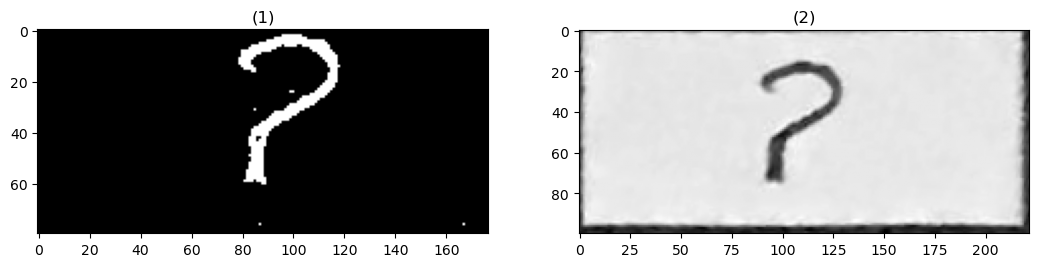

False


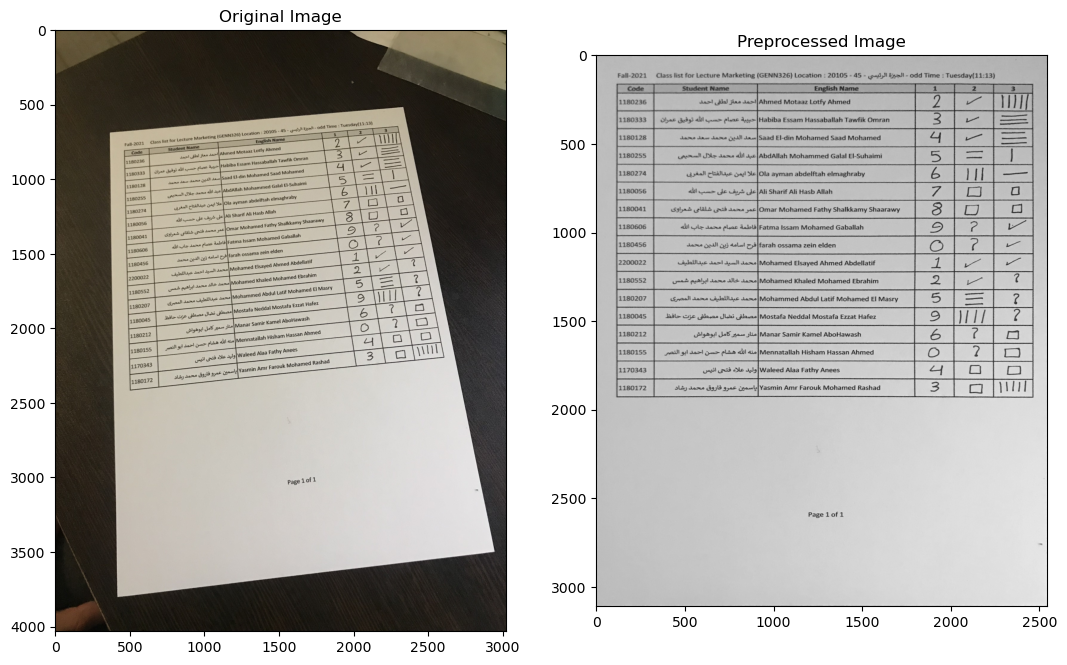

In [343]:
image = load_image( "Grades_Sheet_Dataset/7.jpg" )

preprocessed_image = preprocessing(image)
cells = cell_extraction(preprocessed_image)

values = np.empty((cells.shape[0]-1, cells.shape[1]-2), dtype=object)

value = read_cell(cells[8,4])
# value = read_cell(cells[2,3])
# value = read_cell(cells[3,3])
# value = read_cell(cells[4,3])
# value = read_cell(cells[5,3])
# value = read_cell(cells[6,3])
# value = read_cell(cells[7,3])
# value = read_cell(cells[8,3])
# value = read_cell(cells[9,3])
# value = read_cell(cells[10,3])
# value = read_cell(cells[11,3])
# value = read_cell(cells[12,3])
# value = read_cell(cells[13,3])
# value = read_cell(cells[14,3])
# value = read_cell(cells[15,3])
# value = read_cell(cells[16,3])
# value = read_cell(cells[17,3])

#for r in range(1, cells.shape[0]):
#    values[r-1, 0] = read_cell(cells[r, 0], ocr="id")
#    for c in range(3, cells.shape[1]):
#        cell_image = cells[r, c]
#        values[r-1, c-2] = read_cell(cell_image, ocr="None")

#export_excel(values, "extracted_grades.xlsx")

show_images([image, preprocessed_image], titles=[ "Original Image" ,  "Preprocessed Image" ])